# 🛍️ Mall Customer Segmentation with K-Means

Bu proje, alışveriş merkezi müşterilerini gelir ve harcama davranışlarına göre segmentlere ayırmak amacıyla geliştirilmiştir.  
Amaç, veri odaklı pazarlama stratejileri geliştirmektir.

<details>
<summary><strong>📌 İçindekiler</strong></summary>
    
- Veri Seti Tanıtımı
- Keşifsel Veri Analizi (EDA)
- Veri Hazırlama
- Görselleştirme Analizi
- Optimal Küme Sayısı
- K-Means Kümeleme
- Segment Profilleri
- İş Stratejileri ve Sonuç
</details>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


In [2]:
# Veri işleme ve sayısal işlemler
import numpy as np
import pandas as pd

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py

# Makine öğrenmesi
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Uyarıları gizle
import warnings
warnings.filterwarnings("ignore")

# Plotly notebook modu
py.init_notebook_mode(connected=True)

print("Kütüphaneler yüklendi ✅")


Kütüphaneler yüklendi ✅


In [3]:
# Kaggle dataset yolu
data_path = "/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv"

# Veri setini yükleme
df = pd.read_csv(data_path)

# İlk 5 satır
print("İlk 5 satır:")
display(df.head())

# Sütun isimleri
print(df.columns)

# Veri tipleri
print(df.dtypes)

# Satır ve sütun sayısı
print(df.shape)

# Her sütunda eksik veri sayısı
print(df.isnull().sum())

print(df.describe())

# Veri tipleri ve eksik değer kontrolü
print("\nVeri tipleri ve eksik değerler:")
print(df.info())
print("\nEksik veri sayısı sütun bazında:")
print(df.isnull().sum())

# Sayısal özet istatistikler
print("\nSayısal özet istatistikler:")
display(df.describe())


İlk 5 satır:


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object
(200, 5)
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.00

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## 🔍 Keşifsel Veri Analizi (EDA) – Özet

- Veri seti 200 müşteri ve 5 değişkenden oluşmaktadır.
- Eksik veri bulunmamaktadır.
- Yaş (18–70), gelir (15–137k$) ve harcama skoru (1–99) geniş bir dağılıma sahiptir.
- Bu çeşitlilik, müşteri segmentasyonunun anlamlı sonuçlar üretmesi için uygundur.

💡 **Sonuç:** Veri seti K-Means gibi gözetimsiz öğrenme yöntemleri için temiz ve uygundur.


<details>
<summary><strong>Detaylı EDA Yorumları</strong></summary>
## 🔍 Veri Seti İncelemesi (EDA) – Çıktı Yorumları - 1

---
<details>
<summary>1️⃣ İlk 5 Satır</summary>


* `df.head()` çıktısı bize örnek müşteri verilerini gösteriyor:

```text
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
```

**Yorum:** Veri, `CustomerID`, `Gender`, `Age`, `Annual Income`, `Spending Score` sütunlarından oluşuyor. İlk bakışta mantıklı değerler var. 

---

</details>

<details>
<summary>2️⃣ Sütun İsimleri</summary>



```text
Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')
```

**Yorum:**

* 5 sütun var, hepsi anlamlı isimlendirilmiş.

---

</details>


<details>
<summary>3️⃣ Veri Tipleri</summary>

```text
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object
```

**Yorum:**

* Sayısal: `CustomerID`, `Age`, `Annual Income`, `Spending Score`
* Kategorik: `Gender`
* Bu tipler K-Means ve görselleştirme için uygun.

---
</details>


<details>
<summary>4️⃣ Satır ve Sütun Sayısı</summary>


```text
(200, 5)
```

**Yorum:**

* Toplam 200 müşteri, 5 özellik.
* Küçük ve yönetilebilir bir veri seti.

---
</details>

<details>
<summary>5️⃣ Eksik Veri Kontrolü</summary>


```text
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
```

**Yorum:**

* Hiç eksik veri yok.
* Veri temiz, eksik değer doldurma veya silme gerekmez.

---
</details>

<details>
<summary>6️⃣ Temel İstatistikler (Sayısal Değişkenler)</summary>


```text
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000
```

**Yorum:**

* **Yaş:** 18–70 → geniş yaş dağılımı, farklı müşteri grupları olabilir.
* **Yıllık Gelir:** 15–137 k$ → düşük ve yüksek gelir segmentleri mevcut.
* **Harcama Skoru:** 1–99 → çok çeşitli harcama davranışları var.
* **Ortalama değerler:** Yaş ~39, Gelir ~61 k$, Harcama Skoru ~50 → tipik müşteri profili ortaya çıkıyor.

💡 **Çıkarım:** Veri, K-Means gibi gözetimsiz öğrenme yöntemleri ile müşteri segmentasyonu yapmak için oldukça uygun. Dağılımın genişliği farklı segmentlerin net şekilde ortaya çıkmasını sağlayacaktır.
</details>


---

## 🔍 Keşifsel Veri Analizi (EDA) - 2

<details>
<summary>1️⃣ Veri Tipleri ve Eksik Değerler</summary>

**Yorum:**

- Toplam **200 müşteri** ve **5 sütun** mevcut.  
- `Gender` dışında tüm değişkenler sayısal.  
- **Eksik veri yok**, bu nedenle veri temiz ve kümeleme için uygundur.

</details>

<details>
<summary>2️⃣ Eksik Veri Kontrolü</summary>

**Yorum:**

- Her sütunda eksik değer **0**, dolayısıyla herhangi bir veri temizleme adımı gerekmez.

</details>

<details>
<summary>3️⃣ Sayısal Özet İstatistikler</summary>

**Yorum:**

- **Yaş**: 18–70 → geniş bir yaş dağılımı var.  
- **Yıllık Gelir**: 15–137 k$ → farklı gelir segmentleri mevcut.  
- **Harcama Skoru**: 1–99 → düşükten yükseğe geniş dağılım.  

**Ortalama değerler müşterilerin tipik profilini gösteriyor:**

- Ortalama yaş: ~39  
- Ortalama gelir: ~61 k$  
- Ortalama harcama skoru: ~50  

💡 **Çıkarım:** Veri, K-Means gibi gözetimsiz öğrenme yöntemleri ile müşteri segmentasyonu yapmak için oldukça uygun. Dağılımın genişliği farklı segmentlerin net bir şekilde ortaya çıkmasını sağlayacaktır.

</details>
</details>

<details>
<summary><b><strong>🧹 Aşama 3 – Veri Hazırlama</strong></b></summary>

Bu aşamada kümeleme algoritmasının doğru çalışması için:
- Kimlik bilgileri çıkarılmıştır.
- Kategorik değişkenler sayısallaştırılmıştır.
- Veriler ölçeklendirilmiştir.

</details>


In [4]:
# 🧹 Aşama 3 – Veri Hazırlama

# CustomerID kümeleme için anlamlı değil → çıkarılır
df_model = df.drop(['CustomerID'], axis=1)

# Gender kategorik → sayısallaştırılır
df_model['Gender'] = df_model['Gender'].map({'Male': 0, 'Female': 1})

# Ölçeklendirme
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_model)

print("Veri hazırlandı ve ölçeklendirildi ✅")


Veri hazırlandı ve ölçeklendirildi ✅


In [5]:
"""
1️⃣ Veri Ayıklama ve Hazırlama – Plan:
CustomerID K-Means için gereksiz → çıkarılacak.
Gender kategorik, segmentasyona katmak istersek numerik kodlama yapılacak.
Sayısal değişkenler zaten temiz → aykırı değerleri boxplot ile kontrol edeceğiz.
"""
# Gereksiz sütunu çıkarıyoruz
df_clean = df.drop(['CustomerID'], axis=1)

# Gender sütununu sayısala çeviriyoruz (opsiyonel)
df_clean['Gender'] = df_clean['Gender'].map({'Male':0, 'Female':1})

# Hazırlanan veri çerçevesine bir göz atalım
df_clean.head()


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


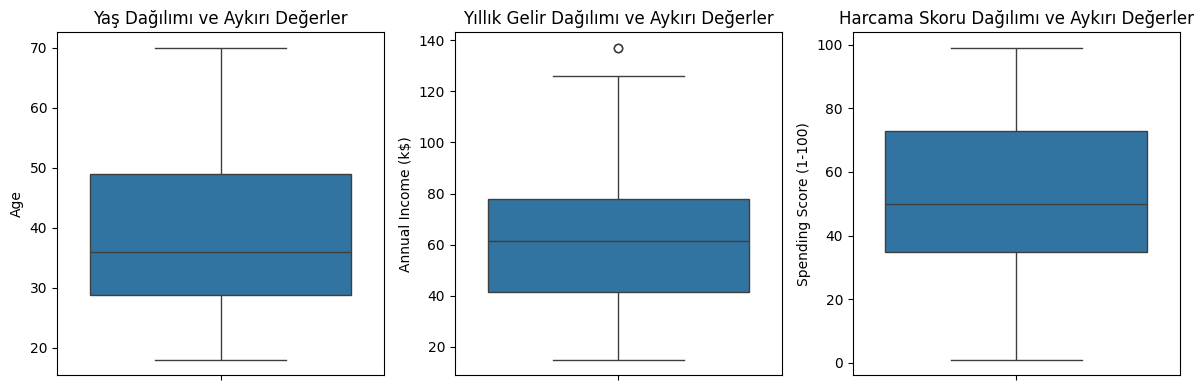

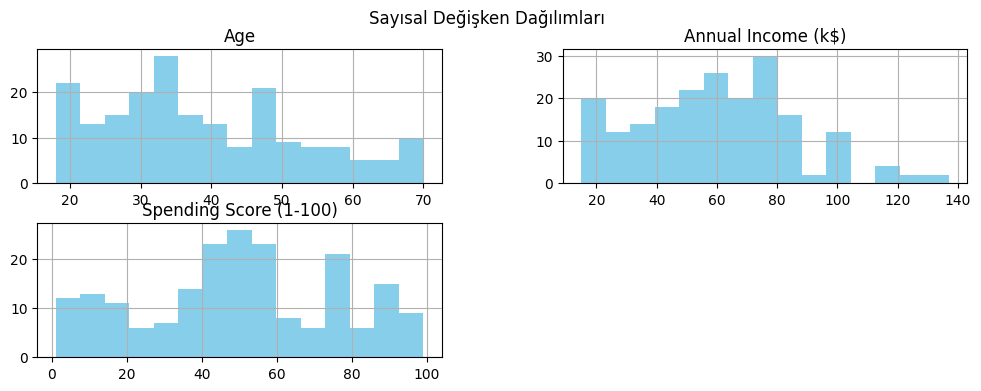

In [6]:
# 📊 Dağılım ve Aykırı Değer Kontrolü

import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot: Aykırı değerleri kontrol etmek için
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.boxplot(y=df_clean['Age'])
plt.title('Yaş Dağılımı ve Aykırı Değerler')

plt.subplot(1,3,2)
sns.boxplot(y=df_clean['Annual Income (k$)'])
plt.title('Yıllık Gelir Dağılımı ve Aykırı Değerler')

plt.subplot(1,3,3)
sns.boxplot(y=df_clean['Spending Score (1-100)'])
plt.title('Harcama Skoru Dağılımı ve Aykırı Değerler')

plt.tight_layout()
plt.show()

# Histogram: Dağılımları görselleştirme
df_clean[['Age','Annual Income (k$)','Spending Score (1-100)']].hist(figsize=(12,4), bins=15, color='skyblue')
plt.suptitle('Sayısal Değişken Dağılımları')
plt.show()

<details>
<summary><strong>📈 2️⃣ Değişkenler Arasındaki İlişkiler (Scatter Plot)</strong></summary>

**Yorumlar:**

1. **Gelir vs Harcama:**

   - Müşteriler belirgin şekilde birkaç kümeye ayrılıyor.
   - Düşük gelirli ama yüksek harcama yapan az sayıda müşteri var.
   - Yüksek gelir ve yüksek harcama grubu, VIP segmenti olabilir.

2. **Yaş vs Harcama:**

   - Genç müşteriler (18–35) harcama skorunda geniş bir dağılıma sahip.
   - Orta yaş ve yaşlılar genelde daha düşük harcama yapıyor.

3. **Yaş vs Gelir:**

   - Yaş arttıkça gelir de artıyor ama çok yüksek gelirli birkaç kişi var.
   - Bu dağılım K-Means ile segmentleri ayırmak için uygun.

💡 **Çıkarım:** Bu scatter plot’lar, veri setindeki doğal kümeleri ve segmentleri önceden görmemizi sağlıyor. Şimdi K-Means algoritmasını çalıştırıp gerçek segmentleri elde edebiliriz.

</details>


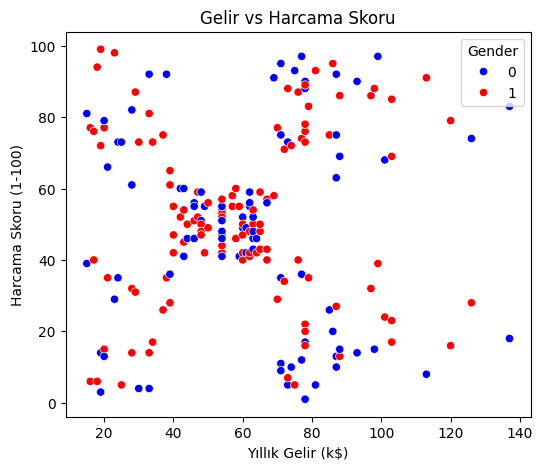

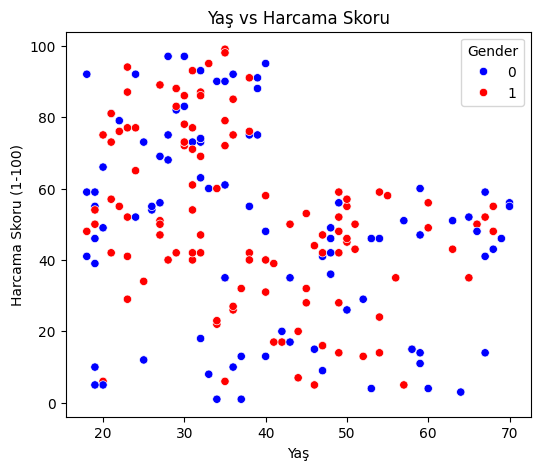

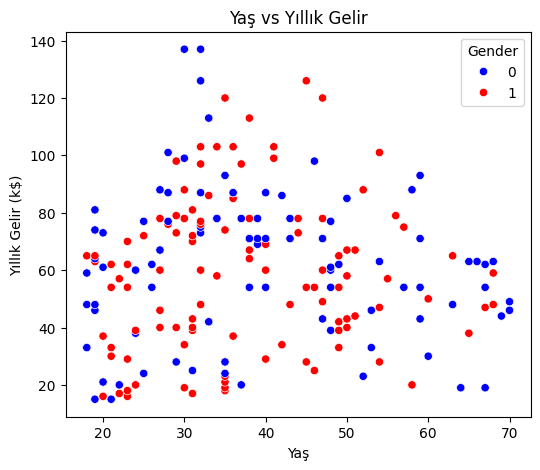

In [7]:
#3️⃣ Scatter Plot – Değişkenler Arası İlişkiler

plt.figure(figsize=(6,5))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Gender', data=df_clean, palette=['blue','red'])
plt.title('Gelir vs Harcama Skoru')
plt.xlabel('Yıllık Gelir (k$)')
plt.ylabel('Harcama Skoru (1-100)')
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x='Age', y='Spending Score (1-100)', hue='Gender', data=df_clean, palette=['blue','red'])
plt.title('Yaş vs Harcama Skoru')
plt.xlabel('Yaş')
plt.ylabel('Harcama Skoru (1-100)')
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x='Age', y='Annual Income (k$)', hue='Gender', data=df_clean, palette=['blue','red'])
plt.title('Yaş vs Yıllık Gelir')
plt.xlabel('Yaş')
plt.ylabel('Yıllık Gelir (k$)')
plt.show()


# 📊 Müşteri Verisi Analizi ve Scatter Plot Yorumları

<details>
<summary><strong>1️⃣ Sayısal Değişkenlerin Dağılımı (Histogramlar)</strong></summary>

**Bu grafikler, veri setindeki sayısal değişkenlerin frekanslarını ve dağılımını gösterir.**

- **Yaş (Age):** 18-70 yaş arası müşteriler mevcut. En yoğun grup 30-35 yaş aralığında.
- **Yıllık Gelir (Annual Income - k$):** 20k$ ile 140k$ arasında. Çoğu müşteri 50-80k$ bandında.
- **Harcama Skoru (Spending Score):** 1-100 arası puan. Orta düzeyde harcama yapan kitle 40-60 puan aralığında.

💡 **Yorum:** Veri seti, genç-orta yaşlı, orta gelirli ve orta harcama düzeyinde yoğun bir müşteri kitlesine sahip. Bu temel dağılım, segmentasyon için iyi bir başlangıç noktasıdır.

</details>

<details>
<summary><strong>2️⃣ Gelir ve Harcama Skoru İlişkisi (Scatter Plot)</strong></summary>

**Bu scatter plot, "Yıllık Gelir" ile "Harcama Skoru" arasındaki ilişkiyi gösterir. Her nokta bir müşteriyi temsil eder.**

- **Cinsiyet:** Mavi noktalar (0) bir cinsiyeti, kırmızı noktalar (1) diğer cinsiyeti temsil ediyor. Noktalar homojen dağılmış, cinsiyetin harcama ve gelire etkisi düşük.
- **5 Ana Segment:**
  1. **Merkez Grup:** Orta gelir (40-65k$), orta harcama (40-60), standart müşteriler.
  2. **Hedef Kitle (Sağ Üst):** Yüksek gelir (80-140k$), yüksek harcama (60-100), VIP müşteriler.
  3. **Tutumlu Zenginler (Sağ Alt):** Gelir yüksek ama harcama düşük (0-40), özel kampanya ile artırılabilir.
  4. **Dikkatsiz/Harcamayı Sevenler (Sol Üst):** Gelir düşük (20-40k$), harcama yüksek, genç veya sadık müşteriler.
  5. **Düşük Potansiyel (Sol Alt):** Hem gelir hem harcama düşük, öncelikli hedef değil.

💡 **İşletme Stratejisi:**  
- Sağ üst VIP grubuna özel sadakat ve promosyon programları.  
- Sağ alt tutumlu zenginlere özel indirim ve tanıtım.  
- Orta grup, işletmenin kemik müşterisi, memnuniyetini korumak kritik.

</details>

<details>
<summary><strong>3️⃣ Yaş ve Harcama / Gelir İlişkisi</strong></summary>

**Yaşın harcama ve gelir üzerindeki etkisini gösteren scatter plotlar.**

- **Yaş vs Harcama:**
  - 18-35 yaş arası müşteriler geniş harcama dağılımına sahip.
  - 40 yaş üstü müşterilerin harcaması genellikle daha düşük ve stabil.
  - Yüksek harcama yapan genç segment, kampanya hedefi olabilir.

- **Yaş vs Gelir:**
  - Yaş arttıkça gelir artma eğiliminde, ancak çok yüksek gelirli birkaç kişi mevcut.
  - Orta yaş (30-50) yüksek gelirli, genç yaş (20-40) yüksek harcama segmenti ile çakışmıyor; pazarlama stratejisinde dikkat edilmesi gerekir.

💡 **Yönetici Özeti:**  
En kârlı segment: **30-40 yaş arası, yüksek gelirli ve yüksek harcama yapan müşteriler**.  
Cinsiyetin harcama davranışları üzerinde belirleyici etkisi yok.

</details>

<details>
<summary><strong>4️⃣ Genel Çıkarımlar ve Sonraki Aşama</strong></summary>

**Özet:**

1. Histogram ve scatter plotlar bize doğal müşteri segmentlerini gösterdi.
2. 5 ana segment tanımlandı (VIP, Standart, Tutumlu Zengin, Dikkatsiz/Harcamayı Sevenler, Düşük Potansiyel).
3. Gelir ve harcama davranışları cinsiyetten bağımsız.
4. Yaş, harcama davranışını belirleyen önemli bir faktör.

💡 **Sonraki Aşama:**  
- Bu segmentleri otomatik olarak belirlemek için **K-Means Kümeleme** uygulanabilir.  
- Her segmente etiket (VIP, Standart, Sadık, vs.) atanabilir ve pazarlama stratejileri bu etiketlere göre şekillendirilebilir.



## 🔍 Optimal Küme Sayısı – Elbow Method

Bu yöntemde, farklı küme sayıları için toplam hata (inertia) hesaplanır.
Dirsek noktasının oluştuğu değer, ideal küme sayısını gösterir.

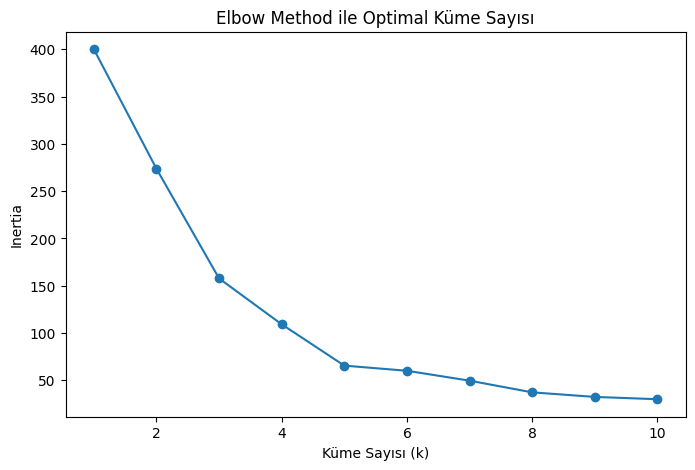

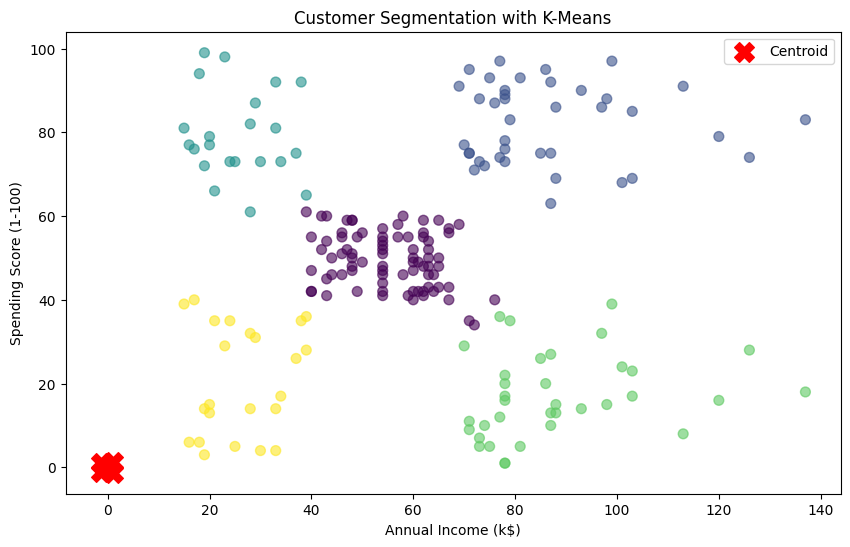

In [8]:
# 📌 4️⃣ K-Means Kümeleme ve Scatter Plot

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Kümeleme için kullanılacak özellikler (ölçeklenmiş)
X = scaled_data[:, [
    df_model.columns.get_loc('Annual Income (k$)'),
    df_model.columns.get_loc('Spending Score (1-100)')
]]

inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method ile Optimal Küme Sayısı')
plt.show()


# Kümelerin sayısı (önceden scatter plot gözlemi ile 5 belirledik)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

# Küme etiketlerini DataFrame'e ekle
df['Cluster'] = clusters

# Kümelerin merkezlerini al
centroids = kmeans.cluster_centers_

# 🎨 Scatter Plot
plt.figure(figsize=(10,6))
plt.scatter(
    df['Annual Income (k$)'], 
    df['Spending Score (1-100)'],
    c=df['Cluster'],
    cmap='viridis',
    s=50,
    alpha=0.6
)

# Centroidleri ekle
plt.scatter(centroids[:,0], centroids[:,1], c='red', s=200, marker='X', label='Centroid')

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Customer Segmentation with K-Means')
plt.legend()
plt.show()


📌 Not: K-Means algoritması ölçeklenmiş veriler üzerinde çalıştırılmıştır.
Ancak görselleştirmelerde, segmentlerin iş birimleri tarafından
daha kolay yorumlanabilmesi için orijinal değişken değerleri kullanılmıştır.

<details>
<summary><strong>📊 K-Means Müşteri Segmentasyonu Scatter Plot Analizi</strong></summary>

**Grafik Özeti:**

Bu scatter plot, müşterilerin **Yıllık Gelir (k$)** ve **Harcama Skoru (1-100)** arasındaki ilişkiyi göstermektedir. Her nokta bir müşteriyi temsil ediyor ve farklı renkler K-Means ile belirlenen **5 ana segmenti** gösteriyor. Kırmızı çarpı işaretleri ise kümelerin merkezlerini (centroid) gösteriyor.

---

### 1️⃣ Segment Analizi

1. **Standart Müşteriler (Orta Grup)**
   * Konum: Yıllık Gelir 40-65k$, Harcama Skoru 40-60
   * Yoğunluk: En kalabalık küme
   * Özellik: Ortalama gelir ve harcama; stabil müşteri kitlesi

2. **VIP / Hedef Kitle (Sağ Üst)**
   * Konum: Yıllık Gelir 80-140k$, Harcama Skoru 60-100
   * Özellik: En değerli müşteriler; yüksek gelir ve yüksek harcama
   * Strateji: Özel kampanyalar ve sadakat programları

3. **Tutumlu Yüksek Gelirliler (Sağ Alt)**
   * Konum: Yüksek gelir, düşük harcama (0-40)
   * Özellik: Parası var ama harcama yapmıyor
   * Strateji: Lüks ürün veya özel indirimlerle harcamayı artırmak

4. **Dikkatsiz / Harcamayı Sevenler (Sol Üst)**
   * Konum: Düşük gelir, yüksek harcama
   * Özellik: Genç veya sadık, harcama yoğun
   * Strateji: Sadakat ve yönlendirme kampanyaları

5. **Düşük Potansiyel (Sol Alt)**
   * Konum: Düşük gelir, düşük harcama
   * Özellik: Öncelikli hedef değil
   * Strateji: Standart promosyonlarla yeterli

---

### 2️⃣ Cinsiyet Dağılımı
* Noktalar: Mavi (0), Kırmızı (1)
* Yorum: Gelir ve harcama davranışları cinsiyetten bağımsız; her segmentte homojen dağılım

---

### 3️⃣ Stratejik Çıkarımlar
* **VIP grubu** odaklı kampanyalar
* **Tutumlu zenginler** için harcama artırıcı teşvikler
* **Orta grup** memnuniyetinin sürekliliği kritik
* **Genç harcamacılar** için yönlendirilmiş kampanyalar

💡 Bu scatter plot, doğal müşteri kümelerini görmemizi ve **K-Means segmentasyonunun stratejik kararlar için kullanılabileceğini** gösteriyor.

</details>


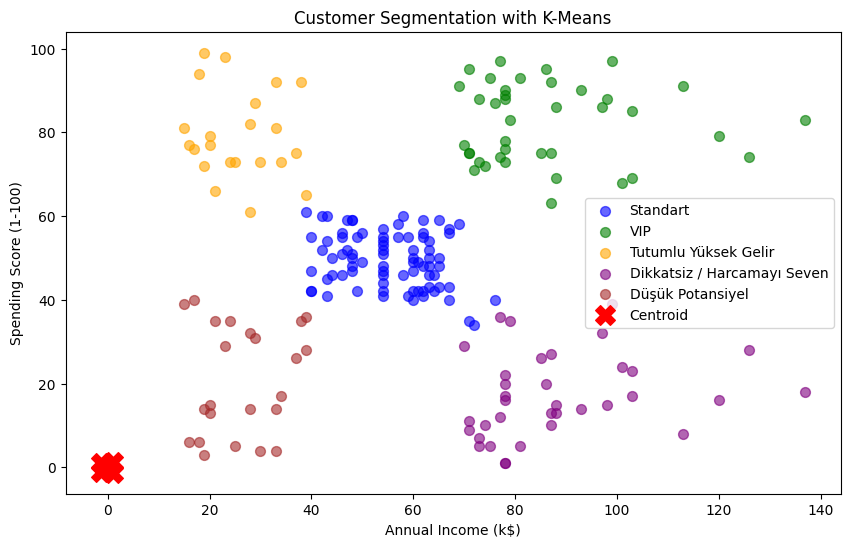

In [9]:
import matplotlib.pyplot as plt

# Segment isimlerini tanımlıyoruz
segment_names = {
    0: "Standart",
    1: "VIP",
    2: "Tutumlu Yüksek Gelir",
    3: "Dikkatsiz / Harcamayı Seven",
    4: "Düşük Potansiyel"
}

# Her cluster için renkler
colors = ['blue', 'green', 'orange', 'purple', 'brown']

plt.figure(figsize=(10,6))

# Her cluster'ı ayrı ayrı çiziyoruz
for cluster_id in range(5):
    cluster_data = df[df['Cluster'] == cluster_id]
    plt.scatter(
        cluster_data['Annual Income (k$)'], 
        cluster_data['Spending Score (1-100)'], 
        s=50, alpha=0.6, 
        c=colors[cluster_id], 
        label=segment_names[cluster_id]
    )

# Centroidleri ekle
plt.scatter(
    centroids[:,0], centroids[:,1], 
    c='red', s=200, marker='X', label='Centroid'
)

plt.title('Customer Segmentation with K-Means')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

## 🔍 Optimal Küme Sayısı – Elbow Method

Bu yöntemde, farklı küme sayıları için toplam hata (inertia) hesaplanır.
Dirsek noktasının oluştuğu değer, ideal küme sayısını gösterir.

<details>
<summary><strong>📊 Her Segmenti Farklı Renk ve İsimlerle Görselleştirme</strong></summary>
1. **Segmentler net ayrılmış**:

   * Mavi: Standart
   * Yeşil: VIP
   * Sarı: Tutumlu Yüksek Gelir
   * Mor: Dikkatsiz / Harcamayı Seven
   * Kahverengi: Düşük Potansiyel

2. **Centroidler doğru konumda**: Kırmızı X’ler kümelerin merkezlerini gösteriyor ve segmentlerin genel konumlarını özetliyor.

3. **Segment isimleri ve renkler okunaklı**: Legend ile segmentler kolayca ayırt edilebiliyor.

4. **Geliştirme fırsatı**:

   * Hover ile müşteri sayısını veya örnek müşteri bilgilerini göstermek için **Plotly** ile interaktif versiyon oluşturabiliriz.
   * Yaş, cinsiyet gibi ek değişkenleri renk veya boyut ile göstermek grafiği daha zengin yapar.
</details>

## 🔍 Optimal Küme Sayısı – Silhouette Score

Silhouette Score, bir veri noktasının kendi kümesine ne kadar iyi
uyduğunu ölçer. Skor -1 ile 1 arasındadır, yüksek değer daha iyidir.


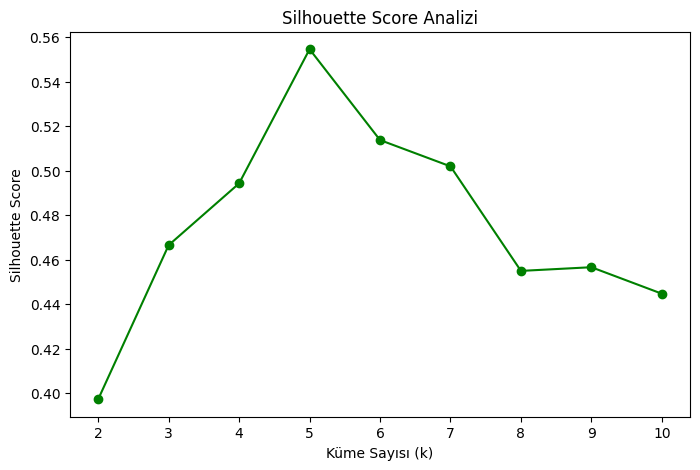

In [10]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Analizi')
plt.show()

📊 **Yorum:**

Elbow Method grafiğinde kırılmanın k=5 civarında olduğu gözlemlenmiştir.
Silhouette Score değerleri de k=5 için göreceli olarak yüksek bir skor sunmaktadır.

Bu nedenle, müşteri segmentasyonu için **5 küme** optimal olarak seçilmiştir.